<a href="https://colab.research.google.com/github/patricksabry1/42028-Deep-Learning/blob/master/Assessment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Image classification - 17 Flowers dataset

The baseline architecture used will be the vgg16 architecture. The original vgg16 architecture will be experimented with first, and then transfer learning will be used to adapt the pre-trained vgg16 model to the flower data. The results of both models will be evaluated and compared for accuracy and training time.


## Data pre-processing

### Initialise dependencies & mount g drive for data extraction

In [1]:
%pip install livelossplot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKerasTF
from tqdm import tqdm
from skimage import feature
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score
import cv2
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/

/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2


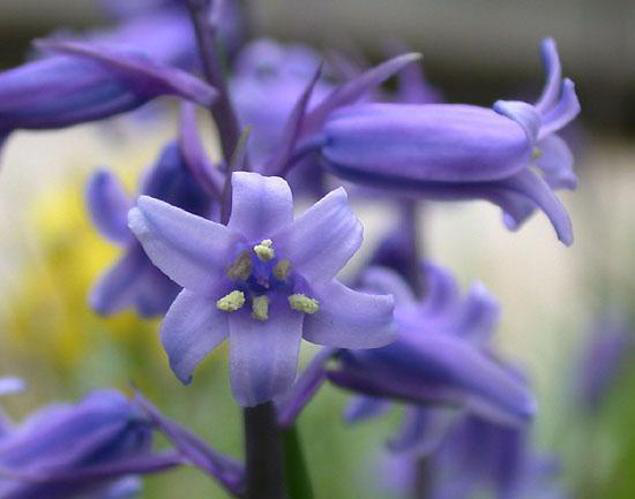

In [3]:
# Display a sample image
from PIL import Image 
Image.open("../assignment-2/17FlowerDataset/Bluebell/image_0241.jpg")

In [0]:
def load_data(fpath):    
    # Resize images to 244x244 for VGG16 compatibility
    img=Image.open(fpath).resize((224,224)) 
    img = np.asarray(img, dtype='float32')

    return img

In [0]:
import os

# Load images as np arrays for easier manipulation
rootdir = '../assignment-2/17FlowerDataset/'
images=[]
labels=[]
total=1361
j=1
i=0

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        images.append(load_data(os.path.join(subdir, file)))
        labels.append(j)
        i += 1
        if i % 80 == 0: j += 1

## Class keys
{1: 'Cowslip', 2: 'Crocus', 3: 'Buttercup', 4: 'Dandelion', 5: 'Daffodil', 6: 'Iris', 7: 'Daisy', 8: 'ColtsFoot', 9: 'Bluebell', 10: 'Fritillary', 11: 'Tigerlily', 12: 'LilyValley', 13: 'Pansy', 14: 'Snowdrop', 15: 'Windflower', 16: 'Tulip', 17: 'Sunflower'}

In [6]:
# All images are converted to np array of shape (1360,224,224,3)
# Labels flattened to np array of shape (1360,1)
images = np.asarray(images) 
labels = np.asarray(labels).reshape(1360,1) 
images.shape

(1360, 224, 224, 3)

In [0]:
# Split data into training and test. Since this is a very small dataset, a 85/15 split was deemed best to avoid overfitting.
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=104)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


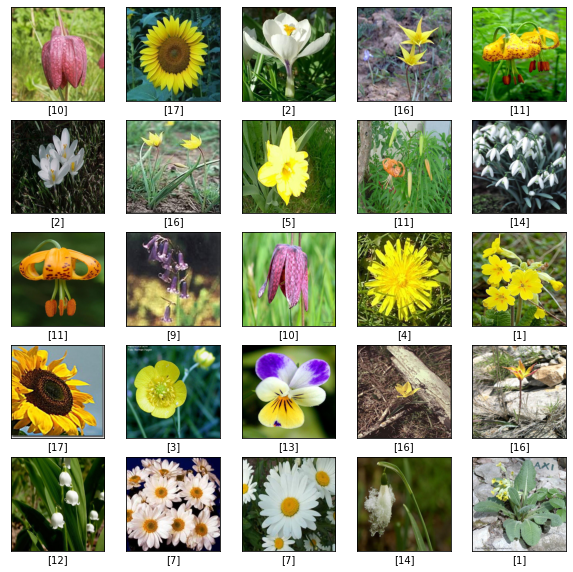

In [8]:
# Plot some sample images with corresponding labels to verify image labelling.
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i]/255, cmap=plt.cm.binary)
    plt.xlabel(y_train[i])

In [0]:
# Dividing images into train and test folders by creating images from arrays
import cv2
import numpy as np
def create_images(data, labels, folder):
    dirname=folder
    
    if not os.path.exists(dirname):
      os.mkdir(dirname)
    n=0
    
    for i in data:
      label_n=labels[n]
      subfolder = folder + "/" + str(label_n) 
      if not os.path.exists(subfolder):
          os.mkdir(subfolder)  
      filepath =  subfolder + "/" + str(n)+ ".jpg"
      cv2.imwrite(filepath, data[n]) 
      n+=1

# Save images to corresponding subfolders
create_images(X_train, y_train, '/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/image_recognition/train') 
create_images(X_test, y_test, '/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/image_recognition/test')
create_images(X_val, y_val, '/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/image_recognition/validation')


## Image data augmentation


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir =os.path.realpath('/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/image_recognition/train')
test_dir = os.path.realpath('/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/image_recognition/test')

image_size = 224

# Configure data augmentation parameters
train_datagen = ImageDataGenerator(
      rescale=1./255,
      horizontal_flip=True,
      rotation_range=10,
      width_shift_range=0.2,
      height_shift_range=0.2,
      fill_mode='nearest'
      )
 
test_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 32
val_batchsize = 10
 
# Fit the train and test images onto the data generators to augment them.
train_generator = train_datagen.flow_from_directory( 
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
test_generator = validation_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 2769 images belonging to 17 classes.
Found 409 images belonging to 17 classes.


## VGG16 implementation for 17Flowers image classification

The VGG16 model initialised with ImageNet weights will be used as a pre-trained model to conduct transfer learning on the 17Flowers dataset. The fully connected layer will not be included and substituted with our own fully connected layer to increase adaptability of the model.

### Baseline model

In [11]:
import tensorflow as tf
from tensorflow.keras import models, layers,optimizers
from keras.preprocessing import image
import tensorflow.keras.applications.vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.layers import Input, Dense

def create_model(baseline=False):

    # Load the model initialised with ImageNet weights
    vgg_transfer = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Use conv layers only for feature extraction
    for layer in vgg_transfer.layers[:-4]:
        layer.trainable = False

    # Initialise model architecture
    model = tf.keras.models.Sequential()
    model.add(vgg_transfer)

    # Add fully connected layers and final output layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(17, activation='softmax'))

    # Plot model exports model visualisation to PNG
    tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=2e-4), metrics=['acc'])

    return model

Using TensorFlow backend.


In [12]:
checkpoint_path = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/image_recognition/"

# LR schedule - reduce learning rate on loss plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001)

callbacks = [reduce_lr, tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5), tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)]
model = create_model()

history = model.fit(
      train_generator,
      shuffle=True,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=50,
      validation_data=test_generator,
      validation_steps=test_generator.samples/test_generator.batch_size,
      callbacks=callbacks,
      verbose=1)


print('training acc.:', history.history['acc'][-1], '\n','test acc.:', (history.history['val_acc'])[-1])

58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/50
87/86 [==============================] - ETA: -2s - loss: 2.5783 - acc: 0.1625
Epoch 00001: saving model to /content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/image_recognition/
87/86 [==============================] - 499s 6s/step - loss: 2.5783 - acc: 0.1625 - val_loss: 2.1030 - val_acc: 0.2958 - lr: 2.0000e-04
Epoch 2/50
87/86 [==============================] - ETA: 0s - loss: 1.6900 - acc: 0.4525
Epoch 00002: saving model to /content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/image_recognition/
87/86 [==============================] - 56s 641ms/step - loss: 1.6900 - acc: 0.4525 - val_loss: 0.9546 - val_acc: 0.6822 - lr: 2.0000e-04
Epoch 3/50
87/86 [==============================] - ETA: 0s - loss: 1.0636 - acc: 0.6594
Epoch 00003: saving model to /content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/image_recognition/
87/86 [==============================] - 55s 633ms/step - loss: 1.0636 - acc: 0

Model results (scratchpad):

VGG16: single FC layer 1024, 0.5 dropout
- RMSProp, train batch_size:100, val batch_size:10 - train acc:99.16% test acc: 91.20%
- RMSProp, train batch_size:64, val batch_size:64 - train acc: 93.90% test acc: 89.73%

VGG16: two FC layers 1024 , 0.5 dropout
- RMSProp, train batch size:32, val batch size:10 - train acc: 99.27% test acc: 94.38%
InceptionV3:
- RMSProp, train batch size: 32, val batch size: 10 - train acc: 88.16% test acc: 44.1%

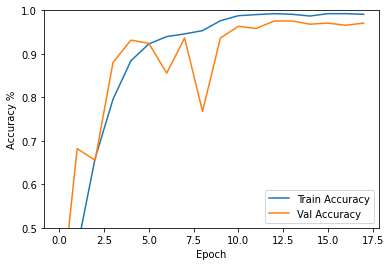

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

model = create_model()
model.load_weights(checkpoint_path)

# plot accuracy hisory
def plot_history(history):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy %')
 plt.plot(history.epoch, np.array(history.history['acc']),
 label='Train Accuracy')
 plt.plot(history.epoch, np.array(history.history['val_acc']),
 label = 'Val Accuracy')
 plt.legend()
 plt.ylim([0.5, 1])

plot_history(history)



# Custom Object Detection

## Faster-RCNN implementation


In [1]:
import os
import sys
import re

%tensorflow_version 1.x
!pip install numpy==1.17.4

repo_url = 'https://github.com/Tony607/object_detection_demo'

num_steps = 1000 
num_eval_steps = 50  

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 8
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Faster-RCNN model selected from config
selected_model = 'faster_rcnn_inception_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file to be used in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size (could be bigger however restricted by random nature of Google Colab's GPU resource allocation)
batch_size = MODELS_CONFIG[selected_model]['batch_size']

TensorFlow 1.x selected.


In [2]:
%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
fatal: destination path 'object_detection_demo' already exists and is not an empty directory.
/content/object_detection_demo
Already up to date.


In [3]:
%cd /content

!git clone --branch r1.13.0 --depth 1 https://github.com/tensorflow/models.git

!pip install tf-slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_embedded_ssd_mobilenet_v1_model_from_config
[       OK ] ModelBuilderTest.test_create_embedded_ssd_mobilenet_v1_model_from_config
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_inception_resnet_v2_model_from_config
Instructions for updating:
Use `tf.cast` instead.
W0609 13:20:27.628864 140435573553024 deprecation.py:323] From /content/models/research/object_detection/anchor_generators/grid_anchor_generator.py:59: to_f

In [4]:
%cd {repo_dir_path}

# Create train data:
!python xml_to_csv.py -i "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-train" -o "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/train_labels.csv" -l "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations"

# Create test data:
!python xml_to_csv.py -i "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-test" -o "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/test_labels.csv" -l "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations"


/content/object_detection_demo
Successfully converted xml to csv.
Generate `/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/label_map.pbtxt`
Successfully converted xml to csv.
Generate `/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/label_map.pbtxt`


In [5]:
# Generate train tfrecord
!python generate_tfrecord.py --csv_input="/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/train_labels.csv" --output_path="/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/train.record" --img_path="/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-train" --label_map "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/label_map.pbtxt"

# Generate test tfrecord
!python generate_tfrecord.py --csv_input="/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/test_labels.csv" --output_path="/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/test.record" --img_path="/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-test" --label_map "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/label_map.pbtxt"



W0609 13:20:35.165400 139653403776896 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0609 13:20:36.173894 139653403776896 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:132: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/train.record


W0609 13:21:45.301222 139760939489152 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0609 13:21:46.429769 139760939489152 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:132: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/gdrive/My Dr

In [0]:
train_record_fname = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/train.record"
test_record_fname = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/test.record"
label_map_pbtxt_fname = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/label_map.pbtxt"

In [7]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [8]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 111M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 70 root   root 4.0K Jun  9 13:21 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000  55M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000  51M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  16K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 5.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.2K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [9]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

In [0]:
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [0]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [12]:
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # Train and test tfrecords
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Training steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Number of target classes 
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [13]:
!cat {pipeline_fname}

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 1
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tru

In [0]:
model_dir = 'training/'
os.makedirs(model_dir, exist_ok=True)

In [15]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-06-09 13:22:23--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.84.72.55, 107.21.11.91, 3.224.101.150, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.84.72.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  37.8MB/s    in 0.3s    

2020-06-09 13:22:23 (37.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [18]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://25f9d3943248.ngrok.io


In [19]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W0609 13:22:36.181015 140263230379904 module_wrapper.py:139] From /content/models/research/object_detection/utils/config_util.py:94: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0609 13:22:36.184247 140263230379904 module_wrapper.py:139] From /content/models/research/object_detection/model_lib.py:573: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0609 13:22:36.184430 140263230379904 model_lib.py:574] Forced number of epochs for all eval validations to be 1.

W0609 13:22:36.184628 140263230379904 module_wrapper.py:139] From /content/models/rese

In [20]:
!ls {model_dir}

checkpoint				     model.ckpt-1000.index
eval_0					     model.ckpt-1000.meta
events.out.tfevents.1591708975.fd7943bedfcb  model.ckpt-338.data-00000-of-00001
export					     model.ckpt-338.index
graph.pbtxt				     model.ckpt-338.meta
model.ckpt-0.data-00000-of-00001	     model.ckpt-674.data-00000-of-00001
model.ckpt-0.index			     model.ckpt-674.index
model.ckpt-0.meta			     model.ckpt-674.meta
model.ckpt-1000.data-00000-of-00001


### Export trained inference graph to reproduce results

In [21]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-1000
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W0609 14:01:35.236268 140499407165312 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:133: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Instructions for updating:
Use `tf.cast` instead.
W0609 14:01:35.242293 140499407165312 deprecation.py:323] From /content/models/research/object_detection/anchor_generators/grid_anchor_generator.py:59: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.

W0609 14:01:35.246416 1404994071653

In [22]:
import os
import glob

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List
PATH_TO_LABELS = label_map_pbtxt_fname

# validation images
PATH_TO_TEST_IMAGES_DIR = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-validation"

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-validation/BloodImage_00408.jpeg', '/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-validation/BloodImage_00409.jpeg', '/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-validation/BloodImage_00410.jpeg']


## Use frozen detection graph to visualize model performance

/content/models/research/object_detection


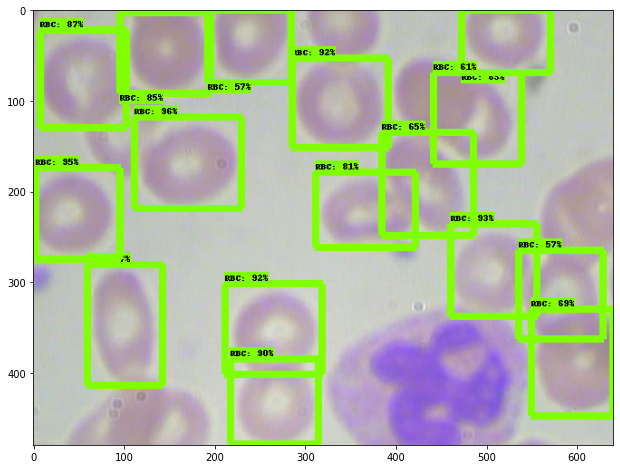

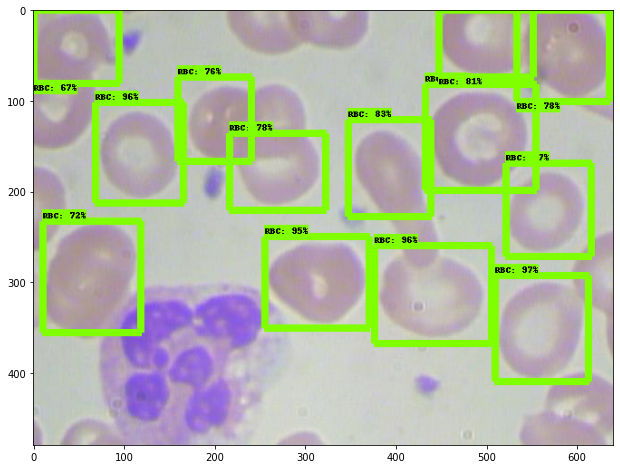

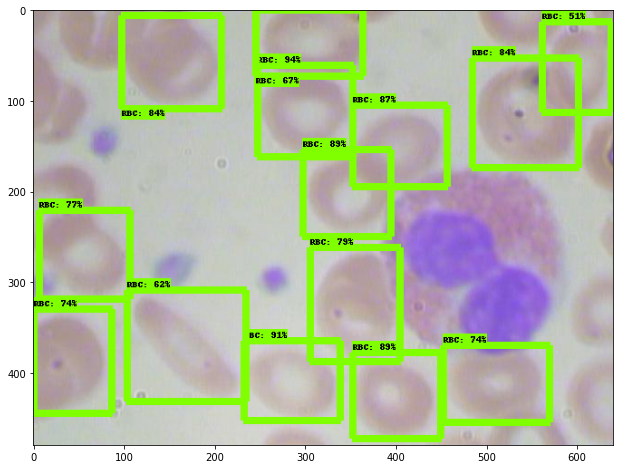

In [23]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

sys.path.append("..")
%matplotlib inline

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # Convert primitive types to avoid runtime errors
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


# For each image in the validation dataset, visualization of the results of a detection.
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

## Single Shot Detector Implementation

In [0]:
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [0]:
train_record_fname = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/train.record"
test_record_fname = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/test.record"
label_map_pbtxt_fname = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/label_map.pbtxt"

In [59]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [0]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [0]:
# Similar to the Faster-RCNN implementation, the SSD training pipeline's parameters are configured below
num_classes = get_num_classes(label_map_pbtxt_fname)

with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [62]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [0]:
model_dir = 'training/'
os.makedirs(model_dir, exist_ok=True)

In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')


In [65]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://25f9d3943248.ngrok.io


In [66]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps=2000 \
    --num_eval_steps=50

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W0609 14:12:16.623275 140020959963008 module_wrapper.py:139] From /content/models/research/object_detection/utils/config_util.py:94: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0609 14:12:16.627216 140020959963008 module_wrapper.py:139] From /content/models/research/object_detection/model_lib.py:573: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0609 14:12:16.627396 140020959963008 model_lib.py:574] Forced number of epochs for all eval validations to be 1.

W0609 14:12:16.627610 140020959963008 module_wrapper.py:139] From /content/models/rese

In [67]:
import re
import numpy as np

output_directory = './fine_tuned_model/ssd'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-1000
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W0609 14:12:59.331667 140513805768576 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:133: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0609 14:12:59.340006 140513805768576 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:348: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0609 14:12:59.340317 140513805768576 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:113: The name tf.placeholder is deprecated. Please use tf.c

In [68]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

import os
import glob

# Path to frozen Inference graph
PATH_TO_CKPT = pb_fname

# Path to label mappings
PATH_TO_LABELS = label_map_pbtxt_fname

# Path to validation dataset
PATH_TO_TEST_IMAGES_DIR =  "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-validation"

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

AssertionError: ignored

/content/models/research/object_detection


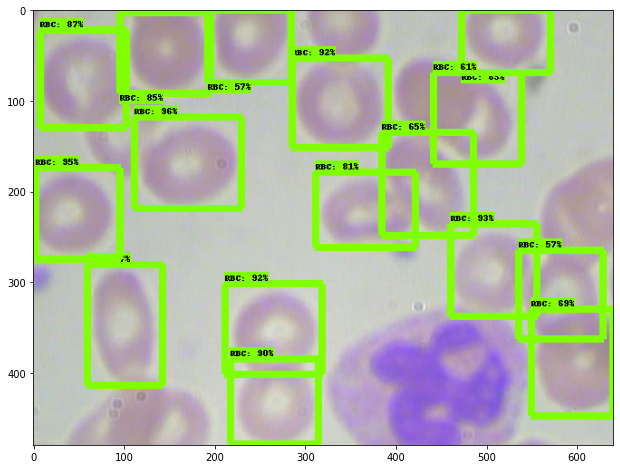

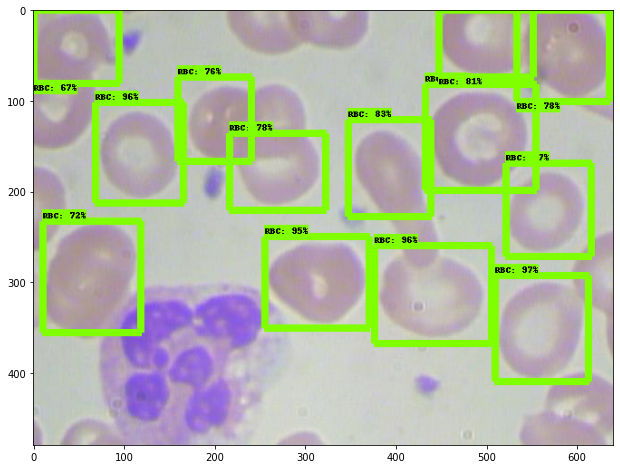

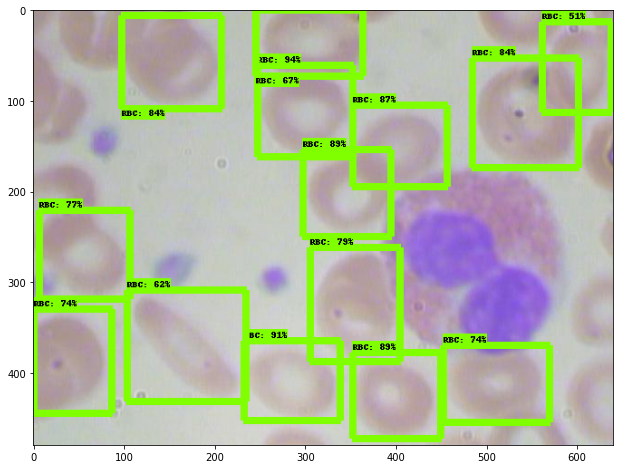

In [69]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
sys.path.append("..")

%matplotlib inline

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # Convert primitive types to avoid runtime errors
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

# For each image in the validation dataset, run inference and visualise object detection performance with annotations
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Run inference on test image 
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    
    # Plot the results.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)